# MCT4052 Workshop 4a: Linear Regressor

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

Regression in a type of supervised machine learning in which, given an input example, the model predicts a quantity (typically one, but multiple quantities are possible with some regression technique). For a quantity we intend a real-valued number.

In this example we work with a folder that includes audio files. As "target" value, we use one audio feature, in particular the average rms energy of an audio signal, which we try to predict givne the the mel-spectrogram. Generally the target value is given together with the dataset (as in the case of the class lables we used in previous workshops).

In this example we use the [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) which is a very basic regression technique (and likely perform poorly). However, the goal of this notebook is to understand the whole process for training and testing a regressor, including how to evaluate or interpret the results.

In this example, the audio files have identical duration, therefore we will compute the features (a vector of per window) over the whole sequence of overlapping window and then we flatten them (they will have the same size across the files, we do not have to worry about that).

In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use("seaborn-v0_8") 
import IPython.display as Ipd
import os
import sklearn

%matplotlib inline
%config IPCompleter.greedy=True

### 1. Loading files from folder, one at a time, computing features N-dim array and target array

Here we build three arrays which contains all key information: such as features, target value (the computed rms, generally this can be a given value rather than computed), and the associated file name. In regression applications we can still backtrace examples that are performing poorly (that's why we keep also the array containing the file names). However, in this case we need to decide what would be a significant magnitude for the error (a sort of treshold) that when exceeded we will backtrace the problematic examples.

In [2]:
sr = 22050

#Instead of writing the code to extract the features and target value we define a function,
#which is more elegant, it's reusable (shorter code) and makes the following code more readable.
#For practicality, the vector features are flattenedm so that that can be stored on a row of a N-dim array

#Mind that the file name is not important here because there is no label to consider (as in the previous examples)

def extract_features_targets(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    features = librosa.feature.melspectrogram(y=signal, sr=sr)
    features = features.flatten()
    
    target = np.mean(librosa.feature.rms(y=signal))
    
    return features, target


#creating an array of zeros of the proper size where we will store computed features and lables
filenames = os.listdir('./data/examples3')

#to set the right number of columns, we call the extract_features_target() function and get the size of the features
num_of_features = extract_features_targets('./data/examples3/'+filenames[0], sr=sr)[0].size
num_of_targets = extract_features_targets('./data/examples3/'+filenames[0], sr=sr)[1].size
features = np.zeros((len(filenames),num_of_features)) 
targets = np.zeros((len(filenames),num_of_targets))

for i in range(len(filenames)):
    print('processing',filenames[i])
    features[i,:], targets[i,:] = extract_features_targets('./data/examples3/'+filenames[i], sr)

print('Done!')

processing reed_acoustic_011-076-100.wav
processing mallet_acoustic_062-101-075.wav
processing guitar_electronic_022-042-025.wav
processing string_acoustic_080-051-127.wav
processing flute_synthetic_000-076-025.wav
processing organ_electronic_057-074-050.wav
processing reed_acoustic_011-045-050.wav
processing string_acoustic_080-048-127.wav
processing flute_synthetic_000-081-127.wav
processing organ_electronic_057-078-075.wav
processing string_acoustic_080-049-127.wav
processing guitar_electronic_022-050-127.wav
processing string_acoustic_080-043-025.wav
processing guitar_electronic_022-049-050.wav
processing mallet_acoustic_062-090-050.wav
processing reed_acoustic_011-062-127.wav
processing mallet_acoustic_062-095-075.wav
processing organ_electronic_057-079-075.wav
processing guitar_electronic_022-045-075.wav
processing mallet_acoustic_062-090-127.wav
processing flute_synthetic_000-080-050.wav
processing reed_acoustic_011-053-100.wav
processing string_acoustic_080-047-100.wav
processi

### 2. Visualizing features

In [3]:
features.shape

(90, 22144)

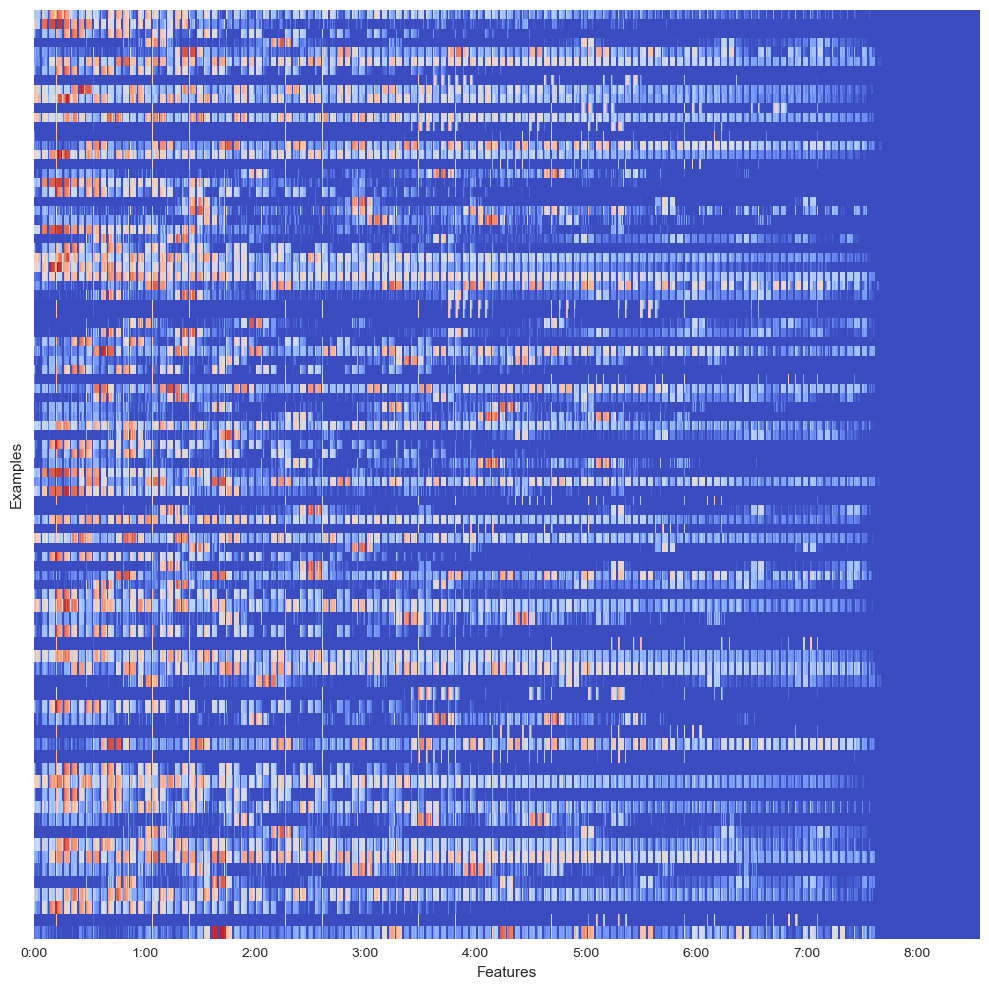

In [4]:
#this plot is not particularly meaningful, but it's just a "flattened" visualization 
#of the melspectrogram for each examples
plt.figure(figsize=(10, 10))
librosa.display.specshow(librosa.power_to_db(features),y_axis='mel', x_axis='time')
plt.ylabel('Examples')
plt.yticks([])
plt.xlabel('Features')
plt.tight_layout()
plt.show()

### 3. Merging and storing everything in a data structure and reloading from the exported file.

In [5]:
#merging everything into a single dataset
dataset = pd.DataFrame(features) #here we wont name the melspec individually, too many, not meaningful, automatically numbered
dataset['targets'] = targets
dataset['filename'] = filenames

#we can save the dataset to a file to resume working without re-computing the features (unless you want to change them)
dataset.to_csv('dataset.csv')
dataset

,0,1,2,3,4,5,6,7,8,9,...,22136,22137,22138,22139,22140,22141,22142,22143,targets,filename
0,1.619635e-04,3.521257e-04,5.595006e-04,7.401028e-04,2.435985e-04,3.115879e-04,4.944558e-04,1.043092e-03,9.639506e-04,2.118835e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.355328,reed_acoustic_011-076-100.wav
1,1.127135e+01,5.925117e+00,8.107454e-02,6.464690e-08,4.436174e-08,3.894775e-08,6.797949e-08,5.546674e-08,4.936953e-08,4.739118e-08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.011969,mallet_acoustic_062-101-075.wav
2,8.920947e+01,7.151340e+01,5.360193e+00,3.028852e-01,7.811649e-02,3.767385e-02,2.357999e-02,1.680322e-02,1.729350e-02,1.876268e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.094726,guitar_electronic_022-042-025.wav
3,6.258327e-01,2.238632e+00,1.090688e+00,2.500907e-01,1.689506e-01,2.481857e-01,3.611142e-01,4.553563e-01,5.625579e-01,6.025459e-01,...,2.873903e-19,1.310536e-19,8.220052e-20,5.193743e-20,2.305491e-20,5.226260e-21,9.161951e-22,9.793246e-23,0.114527,string_acoustic_080-051-127.wav
4,6.820763e-06,3.336029e-05,3.420035e-05,2.263226e-05,2.792690e-05,7.894359e-05,1.017875e-04,7.088725e-05,3.062889e-05,5.648606e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.112875,flute_synthetic_000-076-025.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2.931714e-03,9.611435e-03,8.989877e-03,7.255010e-03,7.865849e-03,2.070490e-03,1.397510e-03,1.429823e-03,1.916471e-03,1.043871e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.205516,reed_acoustic_011-073-075.wav
86,2.100924e-06,3.611296e-06,1.080281e-05,4.492246e-05,4.518997e-05,4.971018e-05,4.402921e-05,6.956865e-06,2.102183e-05,4.102569e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.110068,flute_synthetic_000-081-075.wav
87,3.792088e+01,2.784525e+01,1.215373e+00,6.731948e-02,2.214775e-02,1.732326e-02,2.108524e-02,2.462497e-02,1.785520e-02,1.400413e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.098212,guitar_electronic_022-051-075.wav
88,4.807600e-08,6.844675e-08,4.599857e-09,3.680114e-22,5.462863e-02,2.555398e+00,3.563834e+00,4.393413e-01,4.951905e-02,4.179959e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.254677,organ_electronic_104-024-025.wav


In [6]:
#no we reload from file and re-extract the three separate arrays containing features, labels, and filenames
dataset = pd.read_csv('dataset.csv')
features = dataset.iloc[:, 0:num_of_features].to_numpy() #converting features to numpy array
targets = dataset['targets'] #we keep this as a Pandas Series, it will be handy to trace back poorly performing files
filenames = dataset['filename'].tolist()
print(targets)
print(features)

0     0.355328
1     0.011969
2     0.094726
3     0.114527
4     0.112875
        ...   
85    0.205516
86    0.110068
87    0.098212
88    0.254677
89    0.108916
Name: targets, Length: 90, dtype: float64
[[0.00000000e+00 1.61963471e-04 3.52125702e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.12713518e+01 5.92511654e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 8.92094727e+01 7.15134048e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.70000000e+01 3.79208832e+01 2.78452492e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.80000000e+01 4.80759965e-08 6.84467523e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.90000000e+01 6.60643354e-02 1.01076521e-01 ... 8.18459234e-19
  3.32997194e-19 1.42308747e-19]]


### 4. Splitting the dataset in training and test set

In [7]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, tar_train, tar_test = train_test_split(features, targets, test_size=0.3, random_state=5)

### 5. Creating, training and testing the regressor

In [8]:
# Create linear regression object
regr = sklearn.linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(feat_train, tar_train)

# Make predictions using the testing set
tar_predict = regr.predict(feat_test)

### 6. Regression performance metrics

Generally the prediction of the regressor never matches perfectly the target value. The difference between the two (the absolute value of the subtraction) represents the error. All regression performance metrics use the error as a starting point to assess performances.

All performance metrics that include the term "error" in their name must be contextualized. This is because they measure (to different extend) the overall magnitude error produced by the regressor over the entire test set. Now an error of (for example) 0.5 is absolutely negligible when the magnitude of the target values are in the order of hundreds of thousands, but if the target values are in the unitary range, and error of 0.5 is very significant (not accceptable at all).

Therefore it may be conventient to work with performance metrics that in their computation compare the magnitude of the error with the magnitude of the target values (such as the R2 score).

The following is a (non comprehensive) list of metrics commonly used to assess regression performances:


* *Mean Squared Error*: MSE or Mean Squared Error is one of the most preferred metrics for regression tasks. It is simply the average of the squared difference between the target value and the value predicted by the regression model. As it squares the differences, it penalizes even a small error which leads to over-estimation of how bad the model is. It is preferred more than other metrics because it is differentiable and hence can be optimized better.

* *Mean Absolute Error*: MAE is the absolute difference between the target value and the value predicted by the model. The MAE is more robust to outliers and does not penalize the errors as extremely as mse. MAE is a linear score which means all the individual differences are weighted equally. It is not suitable for applications where you want to pay more attention to the outliers.

* *R² Score*: Coefficient of Determination or R² is another metric used for evaluating the performance of a regression model. The metric helps us to compare our current model with a constant baseline and tells us how much our model is better. The constant baseline is chosen by taking the mean of the data and drawing a line at the mean. R² is a scale-free score that implies it doesn't matter whether the values are too large or too small, the R² will always be less than or equal to 1. There is a misconception among people that the R² score ranges from 0 to 1 but actually, it ranges from -∞ to 1. Due to this misconception, they are sometimes scared why the R² is negative which is not a possibility according to them.

* *Explained Variance*: (also called explained variation): is used to measure the discrepancy between a model and actual data. In other words, it’s the part of the model’s total variance that is explained by factors that are actually present and isn’t due to error variance.

For more regression performance metrisc available in scikit learn, refer to the [metrics page](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

#### For more detailed info check this [post](https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/).


In [9]:
#computing a set of performance metrics

#mean squared error (lower the better)
print('Mean squared error: %.4f'% sklearn.metrics.mean_squared_error(tar_test, tar_predict))

#mean absolute error (lower the better)
print('Mean absolute error: %.4f'% sklearn.metrics.mean_absolute_error(tar_test, tar_predict))

#maximum error (lower the better)
print('Max error squared error: %.4f'% sklearn.metrics.max_error(tar_test, tar_predict))

#median absolute error (lower the better)
print('Median absolute error: %.4f'% sklearn.metrics.median_absolute_error(tar_test, tar_predict))

#coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
print('Coefficient of determination (R2 score): %.4f'% sklearn.metrics.r2_score(tar_test, tar_predict))

#explained variance score: 1 is perfect prediction (it can get arbitrary worse)
print('Explained variance score: %.4f'% sklearn.metrics.explained_variance_score(tar_test, tar_predict))


Mean squared error: 0.0008
Mean absolute error: 0.0186
Max error squared error: 0.0726
Median absolute error: 0.0043
Coefficient of determination (R2 score): 0.8266
Explained variance score: 0.8549


### 7. Displaying errors and files with error above a given treshold

In [10]:
#displaying the individual errors
errors = np.absolute(tar_test - tar_predict)
print(errors)

#displaying names of poorly predicted files
error_threshold = 0.01

print('test examples above the error_threshold')
for index, value in errors.items():
    if value > error_threshold: #setting an arbitrary error threshold
        print(filenames[index], value)


40    2.483859e-03
37    8.902905e-04
57    4.342574e-03
60    4.096501e-02
77    7.748483e-04
20    5.713701e-02
10    1.777112e-02
48    6.308158e-06
34    4.029981e-03
28    3.214252e-04
49    4.001773e-02
32    2.341623e-04
17    3.308224e-02
22    4.341997e-02
23    1.345485e-03
24    1.283301e-08
12    4.148272e-02
63    3.739180e-02
85    7.259593e-02
43    3.246371e-08
35    3.928497e-02
13    2.234265e-03
54    6.875813e-03
74    3.749308e-02
55    8.851574e-05
89    1.277008e-02
6     3.986825e-03
Name: targets, dtype: float64
test examples above the error_threshold
reed_acoustic_011-069-100.wav 0.04096501371552405
flute_synthetic_000-080-050.wav 0.057137011319081096
string_acoustic_080-049-127.wav 0.01777112245718012
reed_acoustic_011-059-025.wav 0.04001772956671798
organ_electronic_057-079-075.wav 0.03308224064636474
string_acoustic_080-047-100.wav 0.04341997241055512
string_acoustic_080-043-025.wav 0.04148271937285397
string_acoustic_080-047-050.wav 0.03739179578075244
ree

### 8. Follow-up activity

1. Identify the cells (as well as the lines of code within the cells) of this notebook that are absolutely necessary to train and test the regressor.
2. Make a fair assessment of the error, explore the dymanic range/magnitude of the target values versus the magnitude of the errors (and the performance metrics).
3. Try to remove add a scaler scaler and assess how performance change. Can you explain why (hint, try to visualize the features before and after scaling)?